# Notebook 03 — Prepare for Modeling

This notebook prepares two **independent** modeling pipelines from the processed dataset:

| Target | Task | Notes |
|---|---|---|
| `is_profitable` | Binary classification | `roi` dropped (leakage) |
| `vote_average` | Regression | `vote_average` is the target |

Steps per pipeline: feature selection → one-hot encoding → train/test split → scaling → baseline model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_squared_error,
                             mean_absolute_error, r2_score)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
print("Libraries loaded.")

Libraries loaded.


## 1 · Load Processed Data

In [6]:
df = pd.read_csv('../data/processed/movies_processed.csv')

# Derive target: is_profitable (ROI > 0)
df['is_profitable'] = (df['roi'] > 0).astype(int)

print(f"Shape: {df.shape}")
print(f"\nColumns ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col:35s}  dtype={df[col].dtype}")
print(f"\nis_profitable distribution:")
print(df['is_profitable'].value_counts().rename({0: 'Not profitable', 1: 'Profitable'}))

Shape: (5352, 25)

Columns (25):
   1. budget                               dtype=int64
   2. id                                   dtype=int64
   3. popularity                           dtype=float64
   4. runtime                              dtype=float64
   5. title                                dtype=str
   6. vote_average                         dtype=float64
   7. vote_count                           dtype=float64
   8. is_collection                        dtype=int64
   9. is_english                           dtype=int64
  10. release_year                         dtype=int64
  11. release_month                        dtype=int64
  12. roi                                  dtype=float64
  13. num_genres                           dtype=int64
  14. num_keywords                         dtype=int64
  15. num_cast                             dtype=int64
  16. num_crew                             dtype=int64
  17. num_production_companies             dtype=int64
  18. num_production_cou

In [9]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
budget,5352.0,NaN,NaN,NaN,31220929.443199,40227868.952045,1.0,5300000.0,17000000.0,40000000.0,380000000.0
id,5352.0,NaN,NaN,NaN,60453.744768,95623.011615,5.0,8730.5,14315.0,59859.25,443319.0
popularity,5352.0,NaN,NaN,NaN,9.817093,13.842215,0.000001,5.499605,8.412657,11.743163,547.488298
runtime,5352.0,NaN,NaN,NaN,110.056241,21.50731,26.0,95.0,106.0,120.0,338.0
title,5352,5252,Beauty and the Beast,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vote_average,5352.0,NaN,NaN,NaN,6.284249,0.896243,1.0,5.7,6.3,6.9,9.1
vote_count,5352.0,NaN,NaN,NaN,736.073057,1253.851066,1.0,79.0,279.0,807.25,14075.0
is_collection,5352.0,NaN,NaN,NaN,0.227952,0.419551,0.0,0.0,0.0,0.0,1.0
is_english,5352.0,NaN,NaN,NaN,0.893685,0.30827,0.0,1.0,1.0,1.0,1.0
release_year,5352.0,NaN,NaN,NaN,1999.744581,15.917324,1915.0,1994.0,2004.0,2011.0,2017.0


## 2 · Correlation Analysis

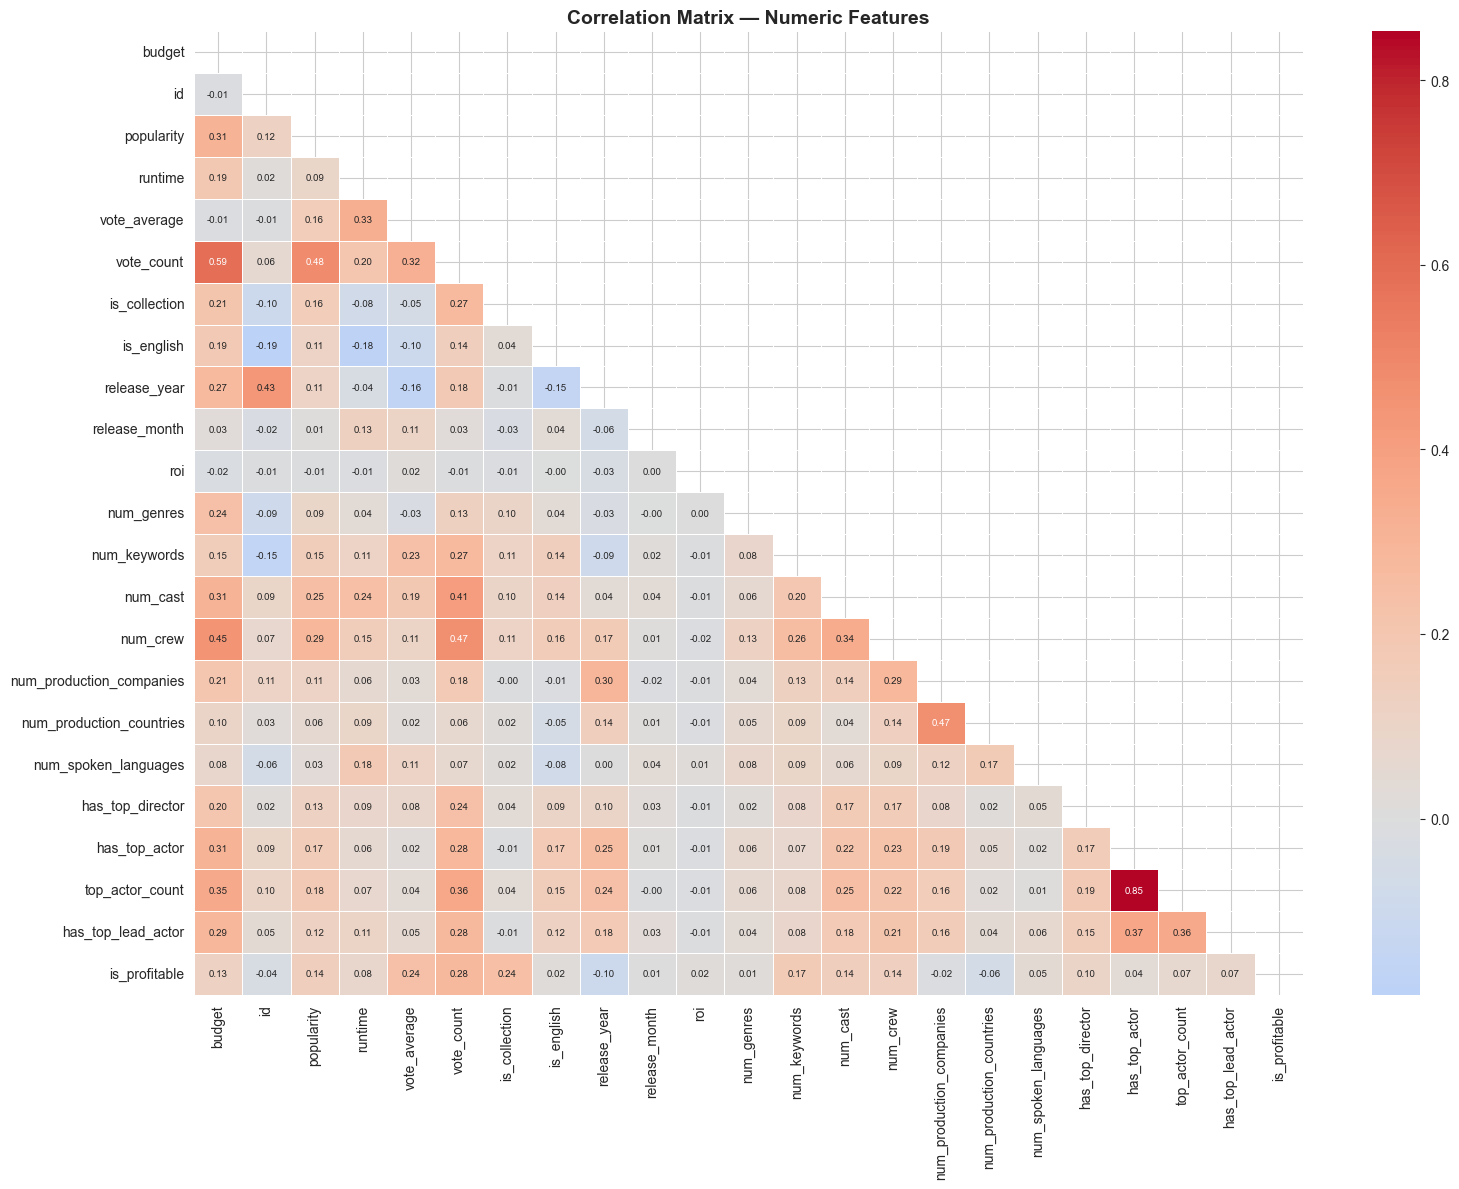

In [10]:
numeric_cols = df.select_dtypes(include='number').columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=0.5, annot_kws={'size': 7})
plt.title('Correlation Matrix — Numeric Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

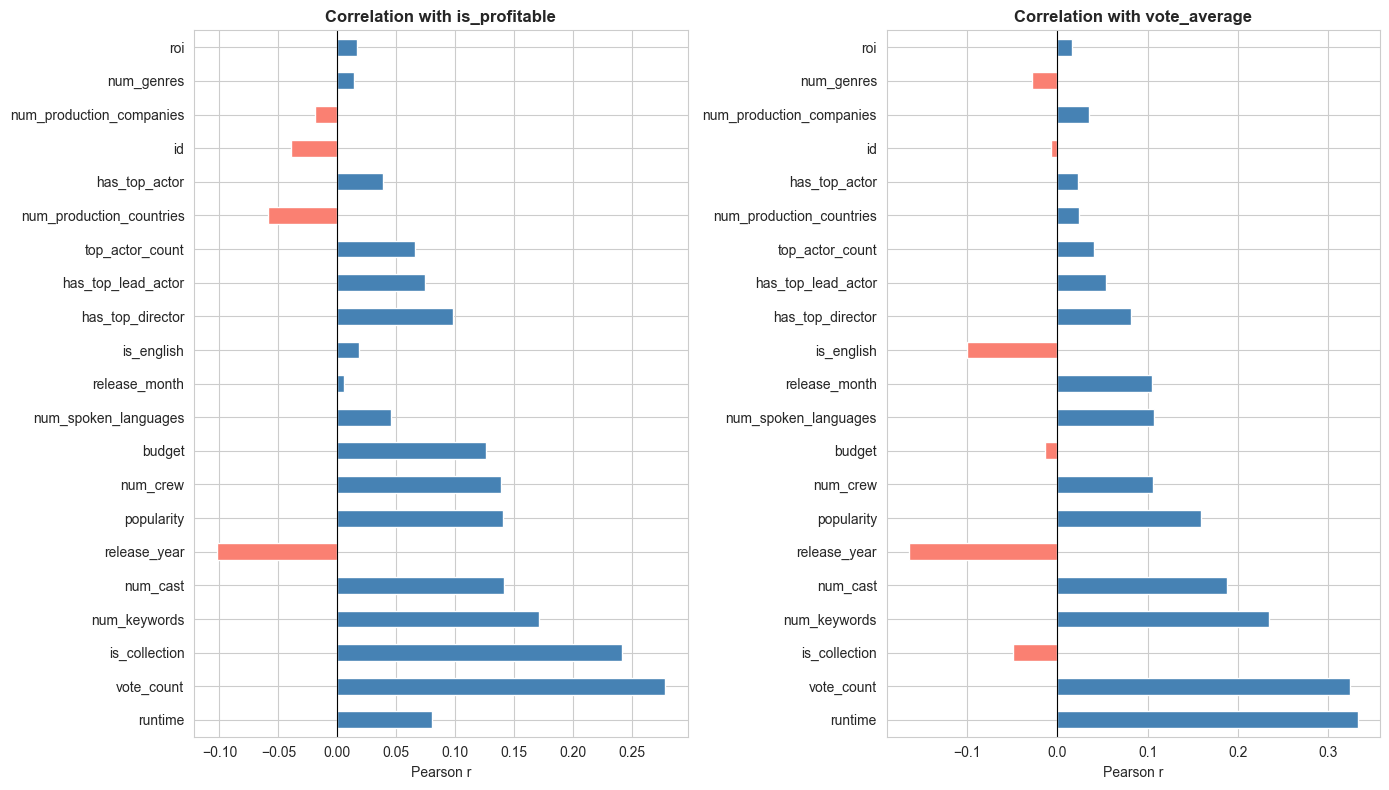

In [11]:
targets = ['is_profitable', 'vote_average']
corr_targets = df[numeric_cols].corr()[targets].drop(targets)
corr_targets = corr_targets.reindex(corr_targets.abs().max(axis=1).sort_values(ascending=False).index)

fig, axes = plt.subplots(1, 2, figsize=(14, 8))
for ax, t in zip(axes, targets):
    corr_targets[t].plot.barh(ax=ax, color=corr_targets[t].apply(
        lambda v: 'steelblue' if v >= 0 else 'salmon'))
    ax.set_title(f'Correlation with {t}', fontsize=12, fontweight='bold')
    ax.axvline(0, color='black', lw=0.8)
    ax.set_xlabel('Pearson r')
plt.tight_layout()
plt.show()

## 3 · Shared Feature Preparation

One-hot encode `primary_genre` and drop identifier columns (`id`, `title`).

In [12]:
# One-hot encode primary_genre
df_model = pd.get_dummies(df, columns=['primary_genre'], drop_first=True, dtype=int)

# Drop identifiers
df_model.drop(columns=['id', 'title'], inplace=True, errors='ignore')

print(f"Shape after encoding: {df_model.shape}")
print(f"\nGenre dummy columns created: "
      f"{[c for c in df_model.columns if c.startswith('primary_genre_')]}")

Shape after encoding: (5352, 42)

Genre dummy columns created: ['primary_genre_Adventure', 'primary_genre_Animation', 'primary_genre_Comedy', 'primary_genre_Crime', 'primary_genre_Documentary', 'primary_genre_Drama', 'primary_genre_Family', 'primary_genre_Fantasy', 'primary_genre_Foreign', 'primary_genre_History', 'primary_genre_Horror', 'primary_genre_Music', 'primary_genre_Mystery', 'primary_genre_Romance', 'primary_genre_Science Fiction', 'primary_genre_TV Movie', 'primary_genre_Thriller', 'primary_genre_Unknown', 'primary_genre_War', 'primary_genre_Western']


## 4 · Pipeline A — Predict `is_profitable` (Classification)

> **Important:** `roi` is dropped because `is_profitable` is derived directly from it (ROI > 0 ⇒ profitable). Keeping it would be data leakage.

In [13]:
# --- Feature / target split ---
drop_clf = ['is_profitable', 'roi']
X_clf = df_model.drop(columns=drop_clf)
y_clf = df_model['is_profitable']

print(f"Features: {X_clf.shape[1]}")
print(f"Samples : {len(X_clf)}")
print(f"\nTarget distribution:")
print(y_clf.value_counts().rename({0: 'Not profitable', 1: 'Profitable'}))
print(f"\nFeature list:")
for i, c in enumerate(X_clf.columns, 1):
    print(f"  {i:2d}. {c}")

Features: 40
Samples : 5352

Target distribution:
is_profitable
Profitable        3743
Not profitable    1609
Name: count, dtype: int64

Feature list:
   1. budget
   2. popularity
   3. runtime
   4. vote_average
   5. vote_count
   6. is_collection
   7. is_english
   8. release_year
   9. release_month
  10. num_genres
  11. num_keywords
  12. num_cast
  13. num_crew
  14. num_production_companies
  15. num_production_countries
  16. num_spoken_languages
  17. has_top_director
  18. has_top_actor
  19. top_actor_count
  20. has_top_lead_actor
  21. primary_genre_Adventure
  22. primary_genre_Animation
  23. primary_genre_Comedy
  24. primary_genre_Crime
  25. primary_genre_Documentary
  26. primary_genre_Drama
  27. primary_genre_Family
  28. primary_genre_Fantasy
  29. primary_genre_Foreign
  30. primary_genre_History
  31. primary_genre_Horror
  32. primary_genre_Music
  33. primary_genre_Mystery
  34. primary_genre_Romance
  35. primary_genre_Science Fiction
  36. primary_genre_T

In [14]:
# --- Train / test split (stratified) ---
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print("Train / Test Split (Classification)")
print("=" * 50)
print(f"Train: {len(X_train_clf)}  |  Test: {len(X_test_clf)}")
for label, y in [('Train', y_train_clf), ('Test', y_test_clf)]:
    pos = y.sum()
    print(f"  {label} — Profitable: {pos} ({pos/len(y)*100:.1f}%)  "
          f"Not profitable: {len(y)-pos} ({(len(y)-pos)/len(y)*100:.1f}%)")

Train / Test Split (Classification)
Train: 4281  |  Test: 1071
  Train — Profitable: 2994 (69.9%)  Not profitable: 1287 (30.1%)
  Test — Profitable: 749 (69.9%)  Not profitable: 322 (30.1%)


In [15]:
# --- Scaling ---
scaler_clf = StandardScaler()
X_train_clf_sc = pd.DataFrame(
    scaler_clf.fit_transform(X_train_clf),
    columns=X_train_clf.columns, index=X_train_clf.index)
X_test_clf_sc = pd.DataFrame(
    scaler_clf.transform(X_test_clf),
    columns=X_test_clf.columns, index=X_test_clf.index)

print("StandardScaler fitted on TRAIN only, applied to both.")
print(f"\nTrain means (should be ~0):\n{X_train_clf_sc.mean().describe()}")
print(f"\nTrain stds  (should be ~1):\n{X_train_clf_sc.std().describe()}")

StandardScaler fitted on TRAIN only, applied to both.

Train means (should be ~0):
count    4.000000e+01
mean    -1.502185e-16
std      1.026753e-15
min     -6.469740e-15
25%     -3.464746e-17
50%      3.941927e-18
75%      3.153542e-17
max      2.423248e-16
dtype: float64

Train stds  (should be ~1):
count    4.000000e+01
mean     1.000117e+00
std      1.465995e-16
min      1.000117e+00
25%      1.000117e+00
50%      1.000117e+00
75%      1.000117e+00
max      1.000117e+00
dtype: float64


Baseline — Logistic Regression
Accuracy : 0.7684

Classification Report:
                precision    recall  f1-score   support

Not Profitable       0.64      0.54      0.58       322
    Profitable       0.81      0.87      0.84       749

      accuracy                           0.77      1071
     macro avg       0.72      0.70      0.71      1071
  weighted avg       0.76      0.77      0.76      1071



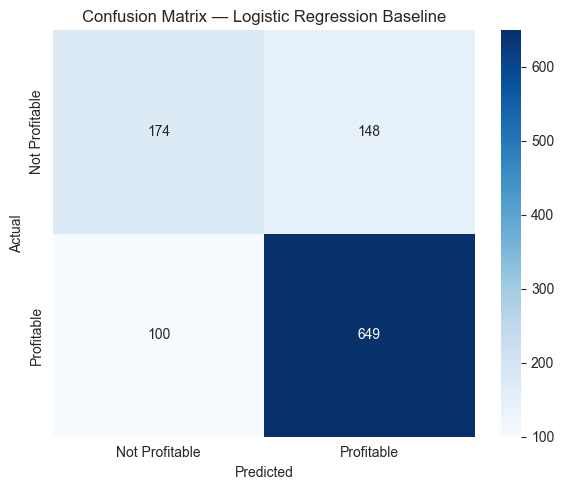

In [16]:
# --- Baseline: Logistic Regression ---
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_clf_sc, y_train_clf)
y_pred_clf = lr.predict(X_test_clf_sc)

print("Baseline — Logistic Regression")
print("=" * 50)
print(f"Accuracy : {accuracy_score(y_test_clf, y_pred_clf):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test_clf, y_pred_clf, target_names=['Not Profitable', 'Profitable'])}")

# Confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y_test_clf, y_pred_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Profitable', 'Profitable'],
            yticklabels=['Not Profitable', 'Profitable'], ax=ax)
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix — Logistic Regression Baseline')
plt.tight_layout(); plt.show()

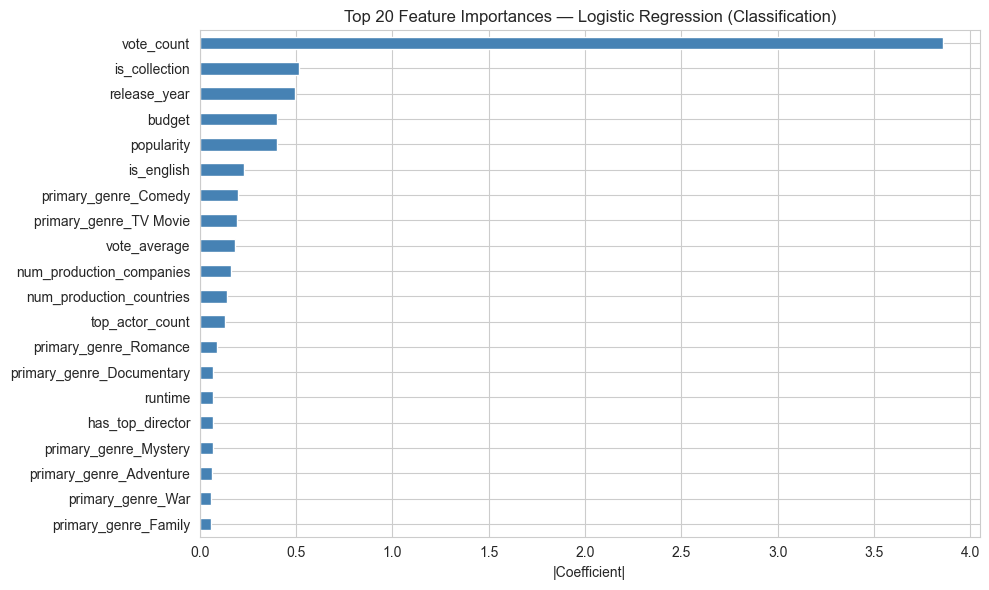

In [17]:
# --- Feature importance (absolute LR coefficients) ---
coef = pd.Series(np.abs(lr.coef_[0]), index=X_train_clf.columns).sort_values(ascending=False)
top20 = coef.head(20)

plt.figure(figsize=(10, 6))
top20.plot.barh(color='steelblue')
plt.xlabel('|Coefficient|')
plt.title('Top 20 Feature Importances — Logistic Regression (Classification)')
plt.gca().invert_yaxis()
plt.tight_layout(); plt.show()

## 5 · Pipeline B — Predict `vote_average` (Regression)

In [18]:
# --- Feature / target split ---
drop_reg = ['vote_average']
X_reg = df_model.drop(columns=drop_reg)
y_reg = df_model['vote_average']

print(f"Features: {X_reg.shape[1]}")
print(f"Samples : {len(X_reg)}")
print(f"\nTarget statistics:")
print(y_reg.describe())
print(f"\nFeature list:")
for i, c in enumerate(X_reg.columns, 1):
    print(f"  {i:2d}. {c}")

Features: 41
Samples : 5352

Target statistics:
count    5352.000000
mean        6.284249
std         0.896243
min         1.000000
25%         5.700000
50%         6.300000
75%         6.900000
max         9.100000
Name: vote_average, dtype: float64

Feature list:
   1. budget
   2. popularity
   3. runtime
   4. vote_count
   5. is_collection
   6. is_english
   7. release_year
   8. release_month
   9. roi
  10. num_genres
  11. num_keywords
  12. num_cast
  13. num_crew
  14. num_production_companies
  15. num_production_countries
  16. num_spoken_languages
  17. has_top_director
  18. has_top_actor
  19. top_actor_count
  20. has_top_lead_actor
  21. is_profitable
  22. primary_genre_Adventure
  23. primary_genre_Animation
  24. primary_genre_Comedy
  25. primary_genre_Crime
  26. primary_genre_Documentary
  27. primary_genre_Drama
  28. primary_genre_Family
  29. primary_genre_Fantasy
  30. primary_genre_Foreign
  31. primary_genre_History
  32. primary_genre_Horror
  33. primary

In [19]:
# --- Train / test split ---
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("Train / Test Split (Regression)")
print("=" * 50)
print(f"Train: {len(X_train_reg)}  |  Test: {len(X_test_reg)}")
print(f"\nTrain target stats:\n{y_train_reg.describe()}")
print(f"\nTest  target stats:\n{y_test_reg.describe()}")

Train / Test Split (Regression)
Train: 4281  |  Test: 1071

Train target stats:
count    4281.000000
mean        6.281289
std         0.900316
min         1.000000
25%         5.700000
50%         6.300000
75%         6.900000
max         9.100000
Name: vote_average, dtype: float64

Test  target stats:
count    1071.000000
mean        6.296078
std         0.880093
min         2.500000
25%         5.700000
50%         6.300000
75%         6.900000
max         9.000000
Name: vote_average, dtype: float64


In [20]:
# --- Scaling ---
scaler_reg = StandardScaler()
X_train_reg_sc = pd.DataFrame(
    scaler_reg.fit_transform(X_train_reg),
    columns=X_train_reg.columns, index=X_train_reg.index)
X_test_reg_sc = pd.DataFrame(
    scaler_reg.transform(X_test_reg),
    columns=X_test_reg.columns, index=X_test_reg.index)

print("StandardScaler fitted on TRAIN only, applied to both.")
print(f"\nTrain means (should be ~0):\n{X_train_reg_sc.mean().describe()}")
print(f"\nTrain stds  (should be ~1):\n{X_train_reg_sc.std().describe()}")

StandardScaler fitted on TRAIN only, applied to both.

Train means (should be ~0):
count    4.100000e+01
mean     6.438650e-17
std      3.942832e-16
min     -9.336143e-17
25%     -1.161831e-17
50%      2.489638e-18
75%      2.655614e-17
max      2.511215e-15
dtype: float64

Train stds  (should be ~1):
count    4.100000e+01
mean     1.000117e+00
std      1.313634e-16
min      1.000117e+00
25%      1.000117e+00
50%      1.000117e+00
75%      1.000117e+00
max      1.000117e+00
dtype: float64


Baseline — Linear Regression
MSE  : 0.4665
RMSE : 0.6830
MAE  : 0.5244
R²   : 0.3971


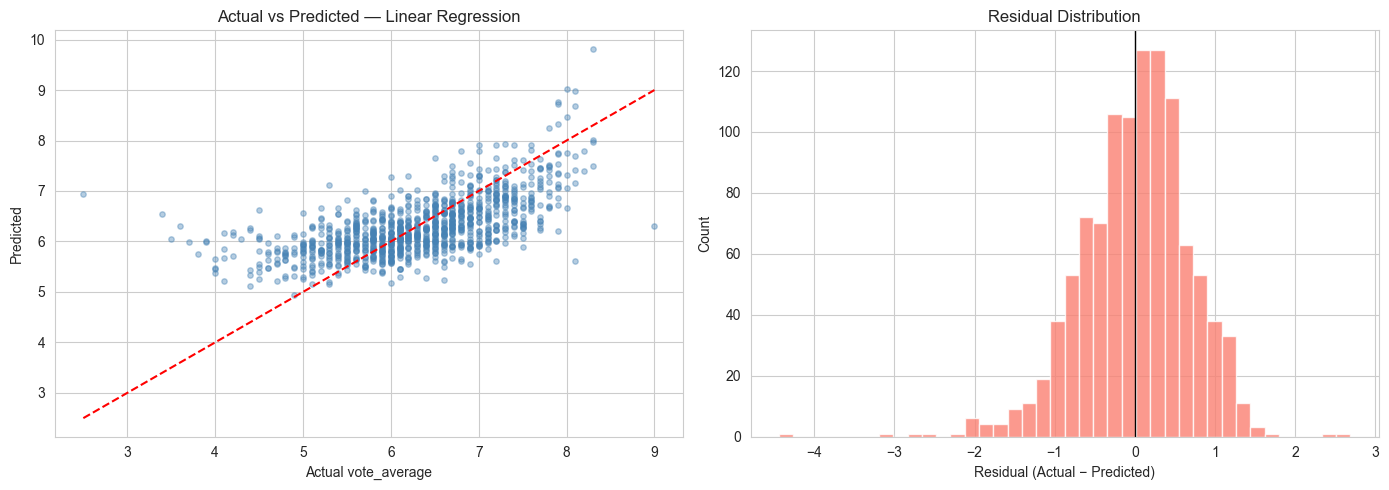

In [21]:
# --- Baseline: Linear Regression ---
linreg = LinearRegression()
linreg.fit(X_train_reg_sc, y_train_reg)
y_pred_reg = linreg.predict(X_test_reg_sc)

mse  = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_reg, y_pred_reg)
r2   = r2_score(y_test_reg, y_pred_reg)

print("Baseline — Linear Regression")
print("=" * 50)
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")

# Actual vs predicted scatter
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test_reg, y_pred_reg, alpha=0.4, s=15, color='steelblue')
mn, mx = y_test_reg.min(), y_test_reg.max()
axes[0].plot([mn, mx], [mn, mx], 'r--', lw=1.5)
axes[0].set_xlabel('Actual vote_average'); axes[0].set_ylabel('Predicted')
axes[0].set_title('Actual vs Predicted — Linear Regression')

residuals = y_test_reg - y_pred_reg
axes[1].hist(residuals, bins=40, color='salmon', edgecolor='white', alpha=0.8)
axes[1].axvline(0, color='black', lw=1)
axes[1].set_xlabel('Residual (Actual − Predicted)'); axes[1].set_ylabel('Count')
axes[1].set_title('Residual Distribution')

plt.tight_layout(); plt.show()

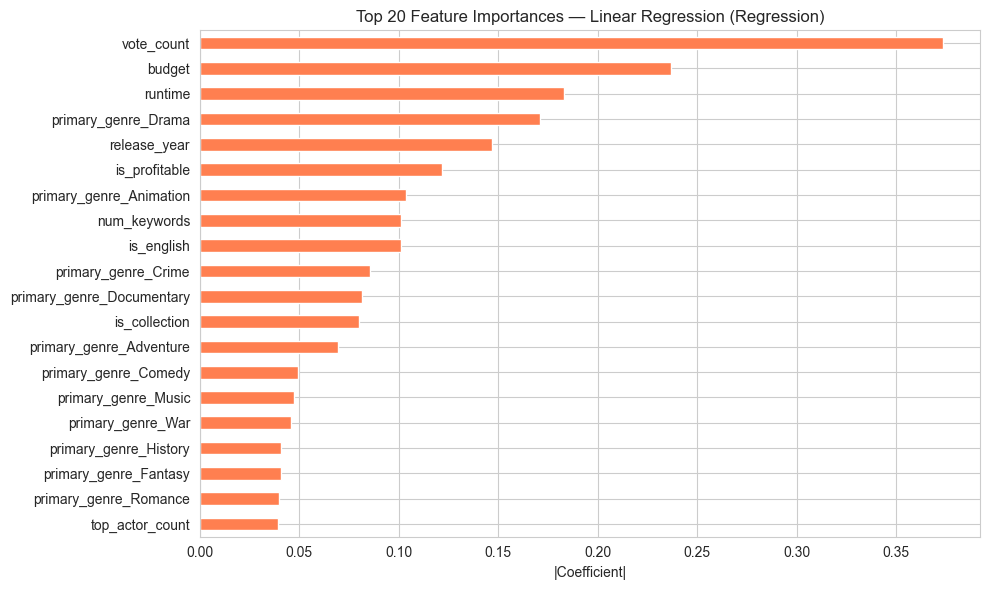

In [22]:
# --- Feature importance (absolute LR coefficients) ---
coef_reg = pd.Series(np.abs(linreg.coef_), index=X_train_reg.columns).sort_values(ascending=False)
top20_reg = coef_reg.head(20)

plt.figure(figsize=(10, 6))
top20_reg.plot.barh(color='coral')
plt.xlabel('|Coefficient|')
plt.title('Top 20 Feature Importances — Linear Regression (Regression)')
plt.gca().invert_yaxis()
plt.tight_layout(); plt.show()

## 6 · Save Prepared Data

In [23]:
os.makedirs('../data/processed', exist_ok=True)

# --- Classification ---
X_train_clf_sc.to_csv('../data/processed/X_train_clf.csv', index=False)
X_test_clf_sc.to_csv('../data/processed/X_test_clf.csv', index=False)
y_train_clf.to_csv('../data/processed/y_train_clf.csv', index=False)
y_test_clf.to_csv('../data/processed/y_test_clf.csv', index=False)

# --- Regression ---
X_train_reg_sc.to_csv('../data/processed/X_train_reg.csv', index=False)
X_test_reg_sc.to_csv('../data/processed/X_test_reg.csv', index=False)
y_train_reg.to_csv('../data/processed/y_train_reg.csv', index=False)
y_test_reg.to_csv('../data/processed/y_test_reg.csv', index=False)

# --- Scalers ---
joblib.dump(scaler_clf, '../models/scaler_clf.pkl')
joblib.dump(scaler_reg, '../models/scaler_reg.pkl')

# --- Feature names ---
pd.Series(X_train_clf.columns.tolist()).to_csv('../data/processed/features_clf.csv', index=False, header=['feature'])
pd.Series(X_train_reg.columns.tolist()).to_csv('../data/processed/features_reg.csv', index=False, header=['feature'])

print("Saved to data/processed/ & models/:")
print("  Classification : X_train_clf, X_test_clf, y_train_clf, y_test_clf, features_clf")
print("  Regression     : X_train_reg, X_test_reg, y_train_reg, y_test_reg, features_reg")
print("  Scalers        : scaler_clf.pkl, scaler_reg.pkl")

Saved to data/processed/ & models/:
  Classification : X_train_clf, X_test_clf, y_train_clf, y_test_clf, features_clf
  Regression     : X_train_reg, X_test_reg, y_train_reg, y_test_reg, features_reg
  Scalers        : scaler_clf.pkl, scaler_reg.pkl


## Summary

| | Classification (`is_profitable`) | Regression (`vote_average`) |
|---|---|---|
| **Task** | Binary (0/1) | Continuous |
| **Dropped** | `roi` (leakage), `id`, `title` | `id`, `title` |
| **Encoding** | One-hot `primary_genre` | One-hot `primary_genre` |
| **Split** | 80/20 stratified | 80/20 |
| **Scaling** | StandardScaler (train-fit) | StandardScaler (train-fit) |
| **Baseline** | Logistic Regression | Linear Regression |

### Next Steps
1. **Notebook 04** — Train & compare models (Random Forest, Gradient Boosting, SVM, etc.)
2. Hyperparameter tuning (GridSearchCV / RandomizedSearchCV)
3. Cross-validation for robust evaluation
4. Final model selection & export